In [80]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('./data/csv/image-data.csv')

# Display the first few rows of the DataFrame
df.head()

,time,mean_gray,count_pixels_lighter,count_pixels_darker,detection_confidence_min,detection_confidence_max,detection_confidence_avg,detection_count,detection_class_worm_count,detection_class_fly_count,detection_class_fly_larva_count
0,2024-06-28T22:59:15.651947,25.383881,1129,1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-28T23:19:42.605933,25.088899,1434,1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-06-28T23:20:15.055077,25.257823,804,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-06-28T23:21:15.022617,25.119673,166,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-28T23:22:15.022551,25.385512,204,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df[['mean_gray']].describe()

,mean_gray
count,162304.000000
mean,31.232943
std,14.144934
min,10.137477
25%,20.126410
50%,29.981545
75%,40.670245
max,113.352662


In [82]:
df[['mean_gray']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162304 entries, 0 to 162303
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mean_gray  162304 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<Axes: xlabel='time'>

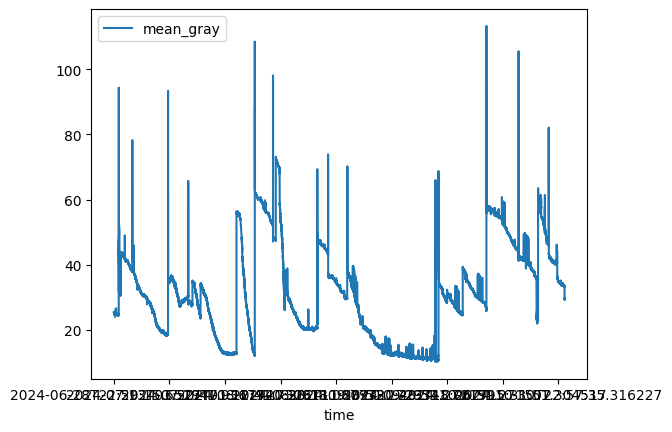

In [83]:
df.plot(x='time', y=['mean_gray'], kind='line')

<Axes: xlabel='time'>

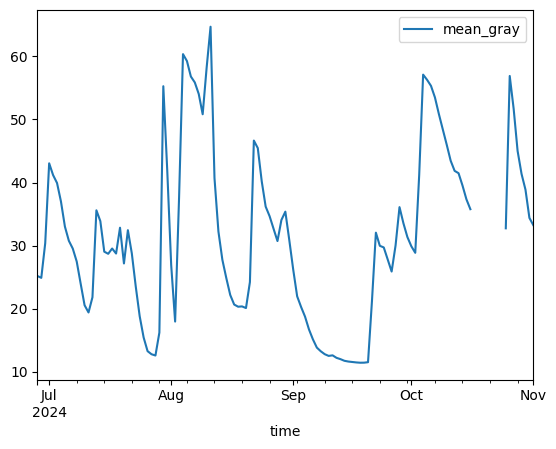

In [165]:
# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Group by month and calculate the mean for 'mean_gray'
df_grouped = df.resample('D', on='time').mean()

# Plot the aggregated data
df_grouped[['mean_gray']].plot(kind='line')

In [151]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2024-06-28 to 2024-11-01
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_gray                        119 non-null    float64
 1   count_pixels_lighter             119 non-null    float64
 2   count_pixels_darker              119 non-null    float64
 3   detection_confidence_min         68 non-null     float64
 4   detection_confidence_max         68 non-null     float64
 5   detection_confidence_avg         68 non-null     float64
 6   detection_count                  68 non-null     float64
 7   detection_class_worm_count       68 non-null     float64
 8   detection_class_fly_count        68 non-null     float64
 9   detection_class_fly_larva_count  68 non-null     float64
dtypes: float64(10)
memory usage: 10.9 KB


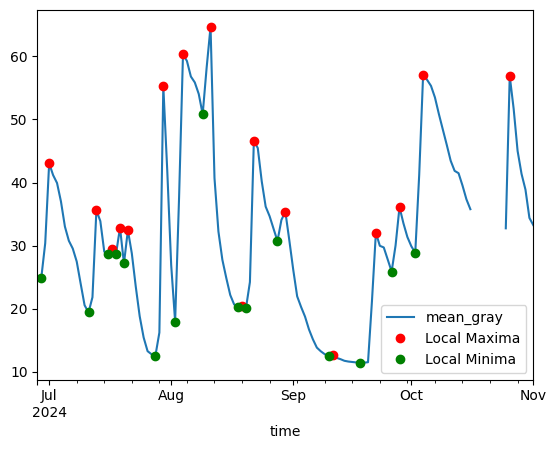

In [166]:
# Plot the aggregated data
fig, ax = plt.subplots()
df_grouped[['mean_gray']].plot(kind='line', ax=ax)

# Find all local maxima and minima
local_maxima = df_grouped[(df_grouped['mean_gray'].shift(1) < df_grouped['mean_gray']) & 
                          (df_grouped['mean_gray'].shift(-1) < df_grouped['mean_gray'])]

local_minima = df_grouped[(df_grouped['mean_gray'].shift(1) > df_grouped['mean_gray']) & 
                          (df_grouped['mean_gray'].shift(-1) > df_grouped['mean_gray'])]

# Plot all local maxima and minima
ax.plot(local_maxima.index, local_maxima['mean_gray'], 'ro', label='Local Maxima')
ax.plot(local_minima.index, local_minima['mean_gray'], 'go', label='Local Minima')

ax.legend()
plt.show()


In [153]:
local_maxima[['mean_gray']].head()

,mean_gray
time,
2024-07-01,43.052295
2024-07-13,35.596787
2024-07-17,29.536543
2024-07-19,32.834471
2024-07-21,32.441701


In [168]:
# Ensure the 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Set 'time' as the index
df.set_index('time', inplace=True)

# Find the maximum value of 'mean_gray' for each day in local_maxima
daily_maxima = df.loc[local_maxima.index].resample('D').max()

# Display the result
daily_maxima[['mean_gray']]

KeyError: 'time'

In [154]:
local_minima[['mean_gray']].head()

,mean_gray
time,
2024-06-29,24.884902
2024-07-11,19.394533
2024-07-16,28.697990
2024-07-18,28.738707
2024-07-20,27.167612


In [129]:
# Combine maxima and minima
combined = pd.concat([local_maxima, local_minima]).sort_index()

# Add a column to indicate if the point is a local maxima or minima
combined['extrema'] = ['maxima' if idx in local_maxima.index else 'minima' for idx in combined.index]

# Filter out minima that do not have a maxima before it
filtered_minima = combined[(combined['extrema'] == 'minima') & (combined.index > combined[combined['extrema'] == 'maxima'].index.min())]

# Filter out maxima that do not have a minima after it
filtered_maxima = combined[(combined['extrema'] == 'maxima') & (combined.index < combined[combined['extrema'] == 'minima'].index.max())]

# Combine the filtered maxima and minima
filtered_combined = pd.concat([filtered_maxima, filtered_minima]).sort_index()

# Define a minimum time difference threshold
time_threshold = pd.Timedelta(days=2)

# Remove maxima and minima that are close together time-wise
filtered_combined = filtered_combined[
    (filtered_combined.index.to_series().diff().abs() > time_threshold) | 
    (filtered_combined.index.to_series().diff(-1).abs() > time_threshold)
]

# Display the combined DataFrame
filtered_combined[['mean_gray', 'extrema']].head()

,mean_gray,extrema
time,,
2024-07-01,43.052295,maxima
2024-07-11,19.394533,minima
2024-07-13,35.596787,maxima
2024-07-16,28.697990,minima
2024-07-21,32.441701,maxima


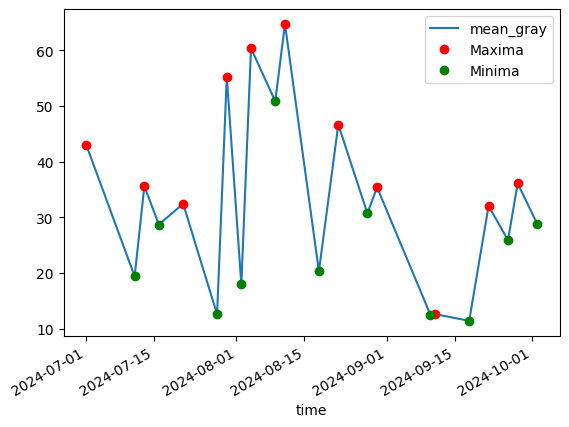

In [130]:
# Plot the filtered_combined DataFrame
ax = filtered_combined.plot(y='mean_gray', kind='line')

# Plot dots for maxima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'maxima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'maxima']['mean_gray'], 
    'ro', label='Maxima')

# Plot dots for minima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'minima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'minima']['mean_gray'], 
    'go', label='Minima')

# Add legend
ax.legend()
plt.show()

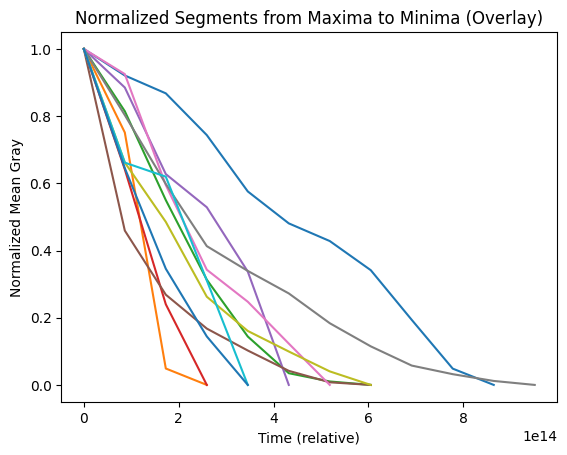

In [131]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the segment between the current maxima and minima
    segment = df_grouped.loc[start:end, 'mean_gray']
    
    # Normalize the segment
    normalized_segment = (segment - segment.min()) / (segment.max() - segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values)

# Add labels and title
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Overlay)')

plt.show()

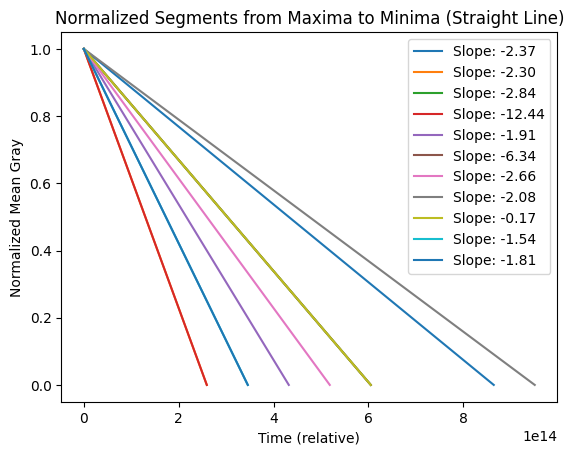

In [145]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the values at the start and end points
    start_value = filtered_combined.loc[start, 'mean_gray']
    end_value = filtered_combined.loc[end, 'mean_gray']
    
    # Create a straight line segment
    line_segment = pd.Series([start_value, end_value], index=[start, end])
    
    # Normalize the segment
    normalized_segment = (line_segment - line_segment.min()) / (line_segment.max() - line_segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Calculate the slope
        delta_y = end_value - start_value
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values, label=f'Slope: {slope:.2f}')
        
# Add labels, title, and legend
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Straight Line)')
ax.legend()

plt.show()


In [160]:
# Initialize an empty list to store the results
slopes = []

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    if filtered_combined['extrema'].iloc[i-1] == 'maxima' and filtered_combined['extrema'].iloc[i] == 'minima':
        start = filtered_combined.index[i-1]
        end = filtered_combined.index[i]
        
        # Calculate the slope
        delta_y = filtered_combined.loc[end, 'mean_gray'] - filtered_combined.loc[start, 'mean_gray']
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Append the result to the list
        slopes.append({
            'maxima_time': start,
            'minima_time': end,
            'slope': slope
        })

# Convert the list to a DataFrame
slopes_df = pd.DataFrame(slopes)

# Add a column with the week number
slopes_df['week_number'] = slopes_df['maxima_time'].dt.isocalendar().week



# Display the DataFrame
slopes_df

,maxima_time,minima_time,slope,week_number
0,2024-07-01,2024-07-11,-2.365776,27
1,2024-07-13,2024-07-16,-2.299599,28
2,2024-07-21,2024-07-28,-2.839319,29
3,2024-07-30,2024-08-02,-12.441615,31
4,2024-08-04,2024-08-09,-1.906818,31
5,2024-08-11,2024-08-18,-6.343522,32
6,2024-08-22,2024-08-28,-2.656241,34
7,2024-08-30,2024-09-10,-2.079763,35
8,2024-09-11,2024-09-18,-0.167063,37
9,2024-09-22,2024-09-26,-1.542091,38


,mean_gray,extrema,exact_time
time,,,
2024-07-01,43.052295,maxima,2024-07-01 00:00
2024-07-11,19.394533,minima,2024-07-11 00:00
2024-07-13,35.596787,maxima,2024-07-13 00:00
2024-07-16,28.697990,minima,2024-07-16 00:00
2024-07-21,32.441701,maxima,2024-07-21 00:00


In [146]:
# Order the slopes_df DataFrame by the slope column
slopes_df_sorted = slopes_df.sort_values(by='slope')

# Display the sorted DataFrame
slopes_df_sorted

,maxima_time,minima_time,slope
3,2024-07-30,2024-08-02,-12.441615
5,2024-08-11,2024-08-18,-6.343522
2,2024-07-21,2024-07-28,-2.839319
6,2024-08-22,2024-08-28,-2.656241
0,2024-07-01,2024-07-11,-2.365776
1,2024-07-13,2024-07-16,-2.299599
7,2024-08-30,2024-09-10,-2.079763
4,2024-08-04,2024-08-09,-1.906818
10,2024-09-28,2024-10-02,-1.811912
9,2024-09-22,2024-09-26,-1.542091
